In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain langchain_openai tavily-python langgraph langchain_groq langchain_cohere

In [ ]:
from google.colab import userdata
import os

os.environ['COHERE_API_KEY'] = userdata.get('COHERE_KEY')
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_KEY')
finnhub_token = userdata.get('X-FINNHUB-TOKEN')
av_key = userdata.get('AV_KEY')

In [ ]:
!pip install -Uq langchain_community langchainhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [ ]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(temperature=0)

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class Response(BaseModel):
  """Response from the model, list containing the symbols"""
  symbols: List[str] = Field(
      description="list of Stock symbols from output query"
  )

In [ ]:
os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY')

In [ ]:
model = llm.bind_tools(tools + [Response])

In [ ]:
from typing import TypedDict, Annotated, Sequence, List
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    question: str
    messages: Annotated[Sequence[BaseMessage], operator.add]
    symbols: List[str]
    sender: str

In [ ]:
from langchain_core.tools import tool
from langchain.pydantic_v1 import BaseModel, Field
import requests
import csv

class Schema(BaseModel):
  symbol: str = Field(description='Stock symbol')
  months: str = Field(description='no. of months the expected earnings is required, value is number only', default='3')

@tool('get_expected_earnings', args_schema=Schema)
def get_expected_earnings(symbol: str, months: str = '3'):
  """use to get the expected earnings of a company, takes in company symbol and no. of months as input, output contain document with earnings"""
  CSV_URL = f'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol={symbol}&horizon={months}month&apikey={av_key}'

  document = ''
  with requests.Session() as s:
      download = s.get(CSV_URL)
      decoded_content = download.content.decode('utf-8')
      cr = csv.reader(decoded_content.splitlines(), delimiter=',')
      for row in cr:
        document += ','.join(row) + '\n'

  return document

In [ ]:
!pip -q install finnhub-python

In [ ]:
import finnhub
from datetime import date, timedelta

@tool('get_insider_sentiment')
def insider_sentiment(symbol: str):
  """
  Get json containing the insider sentiment towards the particular company for 3 months time from current date
  input: Stock symbol
  output: json containing the insider sentiments for 3 month time
  """
  today = date.today()
  start = today - timedelta(days=3 * 30)
  finnhub_client = finnhub.Client(api_key=finnhub_token)

  sentiment = finnhub_client.stock_insider_sentiment(symbol, start, today)

  return sentiment

In [ ]:
@tool('get_insider_transactions')
def insider_transactions(symbol: str):
  """
  Get json containing the insider tranasaction towards the particular company stock for 2 months time from current date
  input: Stock symbol
  output: json containing the insider transactions for 3 month time
  """
  today = date.today()
  start = today - timedelta(days=2 * 30)
  finnhub_client = finnhub.Client(api_key=finnhub_token)

  transactions = finnhub_client.stock_insider_transactions(symbol,  start, today)

  return transactions

In [ ]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=AAPL&apikey={av_key}'
r = requests.get(url)
data = r.json()

print(data)

{'items': '50', 'sentiment_score_definition': 'x <= -0.35: Bearish; -0.35 < x <= -0.15: Somewhat-Bearish; -0.15 < x < 0.15: Neutral; 0.15 <= x < 0.35: Somewhat_Bullish; x >= 0.35: Bullish', 'relevance_score_definition': '0 < x <= 1, with a higher score indicating higher relevance.', 'feed': [{'title': "Apple's Highly Anticipated Artificial Intelligence  ( AI )  Reveal Could Be Only 14 Days Away. Should You Buy the Stock Now?", 'url': 'https://www.fool.com/investing/2024/05/27/apple-artificial-intelligence-ai-buy-stock-now/', 'time_published': '20240527T095000', 'authors': ['Keith Speights'], 'summary': 'The clock is ticking for what could be a huge announcement from the tech giant.', 'banner_image': 'https://g.foolcdn.com/editorial/images/778501/ai-on-smartphone.jpg', 'source': 'Motley Fool', 'category_within_source': 'n/a', 'source_domain': 'www.fool.com', 'topics': [{'topic': 'Financial Markets', 'relevance_score': '0.365926'}, {'topic': 'Manufacturing', 'relevance_score': '0.5'}, {'

In [ ]:
from datetime import datetime

@tool('get_outsider_sentiment')
def get_news_sentiment(symbol: str):
  """
  get news (public/outsider info) with sentiment score about company with stock symbol passed as input. \n
  news will be used for sentiment analysis for finance & stock trade decisions
  output: json containing the metadata and news
  """
  now = datetime.now() - timedelta(days=30)
  formatted_time = now.strftime("%Y%m%dT%H%M")
  url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={symbol}&apikey={av_key}'
  r = requests.get(url)
  data = r.json()

  return data

In [ ]:
from langgraph.prebuilt import ToolInvocation
from langchain_core.messages import ToolMessage
from typing import Literal


# Define the function that determines whether to continue or not
def should_continue(state) -> Literal["continue", "end"]:
    messages = state["messages"]
    last_message = messages[-1]
    # Otherwise if there is, we need to check what type of function call it is
    if last_message.tool_calls[0]["name"] == "Response":
      print(last_message.tool_calls[0]['args']['symbols'])
      return "end"

    return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    messages[-1].content = "what are the Stock market symbols for the companies mentioned in the following sentence use tavily_search_json tool, if not existing say none. finally use Response tool: " + messages[-1].content
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation for each tool call
    tool_invocations = []
    for tool_call in last_message.tool_calls:
        action = ToolInvocation(
            tool=tool_call["name"],
            tool_input=tool_call["args"],
        )
        tool_invocations.append(action)

    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    responses = tool_executor.batch(tool_invocations, return_exceptions=True)
    # We use the response to create tool messages
    tool_messages = [
        ToolMessage(
            content=str(response),
            name=tc["name"],
            tool_call_id=tc["id"],
        )
        for tc, response in zip(last_message.tool_calls, responses)
    ]

    # We return a list, because this will get added to the existing list
    return {"messages": tool_messages}

In [ ]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")


app = workflow.compile()

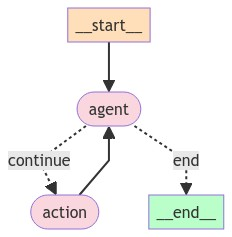

In [ ]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="Is it viable to sell singer srilanka stock and purchase softlogic PLC stocks")]}

In [ ]:
gr = app.invoke(inputs)

KeyboardInterrupt: 

In [ ]:
gr['messages'][-1].tool_calls[0]['args']['symbols']

In [ ]:
@tool
def get_income_statements(symbol: str) -> str:
    """Get company income statement when symbol is provided"""

    # replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
    url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={symbol}&apikey={av_key}'
    r = requests.get(url)
    data = r.json()

    return data